In [1]:
# Preprocessing

import cv2
import mediapipe as mp
import numpy as np
from PIL import Image

mp_face_detection = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.6)

def correct_colors(image):
    """Simple color correction: auto contrast + white balance"""
    img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    l = cv2.equalizeHist(l)
    result = cv2.merge([l, a, b])
    return cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

def crop_face(image_np):
    """Face cropping by key points"""
    results = mp_face_detection.process(image_np)
    if results.detections:
        detection = results.detections[0]
        bbox = detection.location_data.relative_bounding_box
        h, w, _ = image_np.shape
        x, y, w_box, h_box = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)
        x1, y1 = max(0, x - w_box//4), max(0, y - h_box//4)
        x2, y2 = min(w, x + w_box + w_box//4), min(h, y + h_box + h_box//4)
        return image_np[y1:y2, x1:x2]
    else:
        return image_np  # if face is not found


def enhanced_preprocess(image_path, preprocess_clip):
    """Full chain: reading, cropping, correction, CLIP transformation"""
    image_np = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    face = crop_face(image_np)
    corrected = correct_colors(face)
    pil_img = Image.fromarray(corrected)
    return preprocess_clip(pil_img)


In [8]:
import torch
import clip
from PIL import Image
import os

# Loads the CLIP model (ViT-B/32) with image preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

import os

reference_folder = "reference"

reference_embeddings = []
reference_labels = []

for root, dirs, files in os.walk(reference_folder):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(root, file)

            try:
                image = enhanced_preprocess(image_path, preprocess).unsqueeze(0).to(device)
                with torch.no_grad():
                    emb = model.encode_image(image)
                reference_embeddings.append(emb / emb.norm(dim=-1, keepdim=True))

                label = os.path.basename(os.path.dirname(image_path))
                reference_labels.append(label)

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

In [9]:
input_folder = "img"
# Loads target photos from the img/ folder
image_paths = [os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith(".jpg")]

image_embeddings = []
# Going through all images
for path in image_paths:
    # Preprocess
    image = enhanced_preprocess(path, preprocess).unsqueeze(0).to(device)
    # Generates normalized embeddings for each
    with torch.no_grad():
        emb = model.encode_image(image)
    # Add normalized embeddings to the final list
    image_embeddings.append(emb / emb.norm(dim=-1, keepdim=True))


In [10]:
import numpy as np
from torch.nn.functional import cosine_similarity

classified = []

# Going through all images
for img_emb, img_path in zip(image_embeddings, image_paths):
    # Check similarity of each input image’s embedding with all reference embeddings
    sims = [cosine_similarity(img_emb, ref_emb).item() for ref_emb in reference_embeddings]
    
    # Assigns the most similar reference to each image
    best_idx = int(np.argmax(sims))
    # Add to the final list - photo and color type
    classified.append((img_path, reference_labels[best_idx]))


In [11]:
import shutil

# Creates an output folder
output_dir = "clustered_by_color_type"
os.makedirs(output_dir, exist_ok=True)

# Going through all images and corresponding color types
for path, label in classified:
    label_folder = os.path.join(output_dir, label)
    os.makedirs(label_folder, exist_ok=True)
    # Copies classified images into subfolders named after color types
    shutil.copy(path, os.path.join(label_folder, os.path.basename(path)))


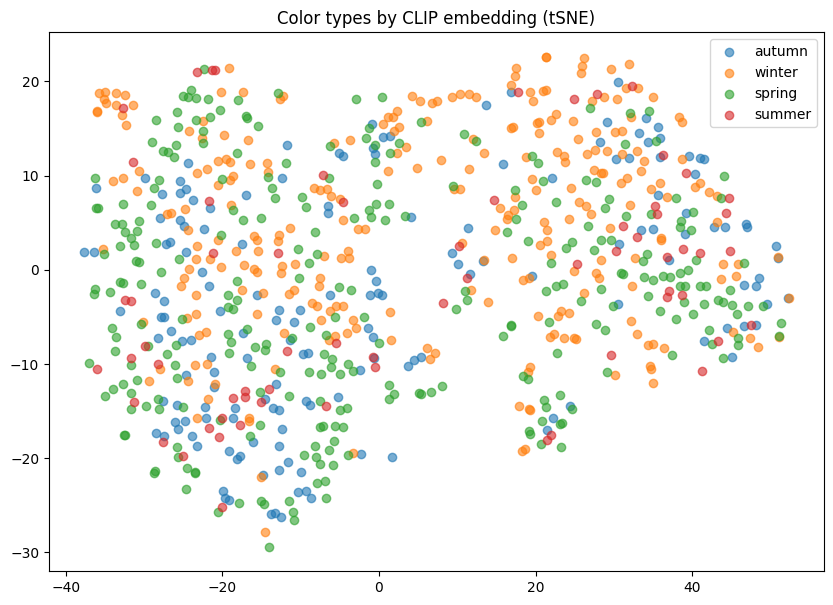

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embs = torch.cat(image_embeddings).cpu().numpy()
labels = [label for _, label in classified]

tsne = TSNE(n_components=2, random_state=0)
proj = tsne.fit_transform(embs)

plt.figure(figsize=(10, 7))
for label in set(labels):
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(proj[idxs, 0], proj[idxs, 1], label=label, alpha=0.6)

plt.legend()
plt.title("Color types by CLIP embedding (tSNE)")
plt.show()


In [4]:
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
from rembg import remove
import os

mp_face_detection = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.6)

def crop_face(image_np):
    results = mp_face_detection.process(image_np)
    if results.detections:
        detection = results.detections[0]
        bbox = detection.location_data.relative_bounding_box
        h, w, _ = image_np.shape
        x, y, w_box, h_box = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)
        x1, y1 = max(0, x - w_box//4), max(0, y - h_box//4)
        x2, y2 = min(w, x + w_box + w_box//4), min(h, y + h_box + h_box//4)
        return image_np[y1:y2, x1:x2]
    else:
        return image_np 

def remove_background(image_np):
    pil_image = Image.fromarray(image_np)
    removed = remove(pil_image)
    return np.array(removed.convert("RGB"))

def crop_and_remove_background(image_np):
    cropped = crop_face(image_np)
    return remove_background(cropped)

input_folder = "DATASET"
output_folder = "faces_cleaned_only"
os.makedirs(output_folder, exist_ok=True)

for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            input_path = os.path.join(root, file)
            try:
                image_np = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
                processed_np = crop_and_remove_background(image_np)
                processed_pil = Image.fromarray(processed_np)

                relative_subfolder = os.path.relpath(root, input_folder)
                save_dir = os.path.join(output_folder, relative_subfolder)
                os.makedirs(save_dir, exist_ok=True)

                save_path = os.path.join(save_dir, file)
                processed_pil.save(save_path)
                print(f"Saved: {save_path}")

            except Exception as e:
                print(f"Error processing {input_path}: {e}")


I0000 00:00:1752573780.487074    8878 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752573780.507028   12465 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 575.64.03), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
W0000 00:00:1752573780.516310   12458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Saved: faces_cleaned_only/summer/0 (1390).jpg
Saved: faces_cleaned_only/summer/makeup356.jpeg
Saved: faces_cleaned_only/summer/000556.jpg
Saved: faces_cleaned_only/summer/001518.jpg
Saved: faces_cleaned_only/summer/0 (2154).jpg
Saved: faces_cleaned_only/summer/makeup692.jpeg
Saved: faces_cleaned_only/summer/0 (2498).jpg
Saved: faces_cleaned_only/summer/002522.jpg
Saved: faces_cleaned_only/summer/no_makeup930.jpeg
Saved: faces_cleaned_only/summer/no_makeup786.jpeg
Saved: faces_cleaned_only/summer/00000230.jpg
Saved: faces_cleaned_only/summer/no_makeup268.jpeg
Saved: faces_cleaned_only/summer/0 (1441).jpg
Saved: faces_cleaned_only/summer/Colourtheoryhgj.004.png
Saved: faces_cleaned_only/summer/0 (358).jpg
Saved: faces_cleaned_only/summer/002858.jpg
Saved: faces_cleaned_only/summer/0 (1942).jpg
Saved: faces_cleaned_only/summer/no_makeup515.jpeg
Saved: faces_cleaned_only/summer/no_makeup639.jpeg
Saved: faces_cleaned_only/summer/003224.jpg
Saved: faces_cleaned_only/summer/no_makeup867.jpeg
